In [1]:
%matplotlib inline
import os
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import Line2D

[ca-ws:1426365] mca_base_component_repository_open: unable to open mca_accelerator_rocm: libamdhip64.so.6: cannot open shared object file: No such file or directory (ignored)


In [2]:
os.system('rm *.h5 *.xml')

0

We will add an arbitrary out-of-core fuel salt depletable material, with the same material definition and placed it outside of the core region (subjected to only decay). We will then set up transfer rates for the all fuel salt inventory from in-core to out-of core and vice versa as a function of their residence times. 

In [36]:
# Instantiate some Materials and register the appropriate Nuclides
uf4 = openmc.Material(name='UF4')
uf4.set_density('g/cm3', 4.5)
uf4.add_element('U', 1., enrichment=2.4)
uf4.add_element('F', 4.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

ofc_uf4 = uf4.clone()
ofc_uf4.name = 'UF4_ofc'
# Define overall material
material = openmc.Materials([uf4, helium, zircaloy, borated_water, ofc_uf4])

In [37]:
# Define surfaces
width = 1.25984
height = 200
ofc_r = 2
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=-59, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')
ofc_surf = openmc.Sphere(x0 = 15, r = ofc_r, boundary_type = 'vacuum') 

# Define cells
fuel = openmc.Cell(fill=uf4, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
ofc_fuel = openmc.Cell(fill=ofc_uf4, region=-ofc_surf)
root = openmc.Universe(cells=[fuel, gap, clad, msr, ofc_fuel])
# Define overall geometry
geometry = openmc.Geometry(root)

In [38]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.IndependentSource(space=uniform_dist)

#Build the model
model = openmc.Model(geometry=geometry, materials=material, settings=settings)

<Axes: xlabel='x [cm]', ylabel='z [cm]'>

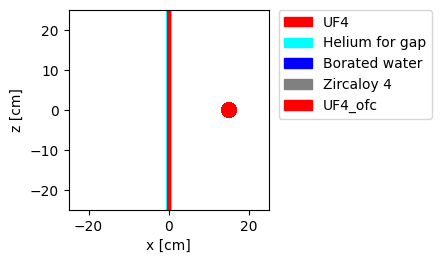

In [39]:
# Create plot
colors = {uf4:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray', ofc_uf4: 'red'}
root.plot(width=(50, 50), origin=(0,0,0), pixels=(200, 200), basis='xz', color_by='material', colors=colors, legend=True)

To simulate the continuous circulation of fuel salt from in-core to out-of-core and vice versa, we can set up inventory transfers, by making use of `TransferRates` methodology, with trasnfer rates $\lambda_i$ defined as: 

\begin{equation}
\lambda_i = \frac{1}{V_i \dot{m}_i}
\end{equation}

where $V_i$ is the fuel salt volume of the material we're transferring from and $\dot{m}_i$ the flow rate. 

In this example, we will set the fuel salt out-of-core volume being 3 times larger than the one in-core.

In [52]:
# Set material volume for depletion.
uf4.volume = pi * fuel_or.r**2 * height
ofc_uf4.volume  = 3*uf4.volume 

# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0]  # days
power = 1.0e5  # W

# Transfer all elements from in-core to out-of-core and vice-versa
all_elements = list(openmc.data.ELEMENT_SYMBOL.values())
all_elements.remove('He') #still haven't figure out here
flow_rate = 0.1 #litres/sec
lambda_in = 1 / (uf4.volume / 1000 / flow_rate)
lambda_out = 1 / (ofc_uf4.volume / 1000 / flow_rate)
op = openmc.deplete.CoupledOperator(model)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.add_transfer_rate(uf4, all_elements, lambda_in, destination_material=ofc_uf4)
integrator.add_transfer_rate(ofc_uf4, all_elements, lambda_out, destination_material=uf4)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Sn115 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn115.h5
 Reading Sn116 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn116.h5
 Reading Sn117 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn117.h5
 Reading Sn118 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn118.h5
 Reading Sn119 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn119.h5
 Reading Sn120 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn120.h5
 Reading Sn122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn122.h5
 Reading Sn124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn124.h5
 Reading H1 from /home/lorenzo/nuclear_data/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/nuclear_data/endfb80_hdf5/H2.h5
 Reading B10 from /home/lorenzo/nuclear_data/endfb80_hdf5/B10.h5
 Reading B11 from /home/lorenzo/nuclear_data/endfb80_hdf5/B11.h5
 Reading O16 from /home/lorenzo/nuclear_data/endfb80_hdf5/O16.h5
 Reading O17 from /home/lorenzo/nuclear_data/endfb80_hdf5/O17.h5
 Reading O18 from /home/lorenzo/nuclear_data/endfb80_hdf5/O18.

 Reading Mg24 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg24.h5
 Reading Mg25 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg25.h5
 Reading Mg26 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mg26.h5
 Reading Al26_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Al26_m1.h5
 Reading Al27 from /home/lorenzo/nuclear_data/endfb80_hdf5/Al27.h5
 Reading Si28 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si28.h5
 Reading Si29 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si29.h5
 Reading Si30 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si30.h5
 Reading Si31 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si31.h5
 Reading Si32 from /home/lorenzo/nuclear_data/endfb80_hdf5/Si32.h5
 Reading P31 from /home/lorenzo/nuclear_data/endfb80_hdf5/P31.h5
 Reading S32 from /home/lorenzo/nuclear_data/endfb80_hdf5/S32.h5
 Reading S33 from /home/lorenzo/nuclear_data/endfb80_hdf5/S33.h5
 Reading S34 from /home/lorenzo/nuclear_data/endfb80_hdf5/S34.h5
 Reading S35 from /home/lorenzo/nuclear_data/endfb80_hdf5/S35.h5

 Reading Ar39 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar39.h5
 Reading Ar40 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar40.h5
 Reading Ar41 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ar41.h5
 Reading K39 from /home/lorenzo/nuclear_data/endfb80_hdf5/K39.h5
 Reading K40 from /home/lorenzo/nuclear_data/endfb80_hdf5/K40.h5
 Reading K41 from /home/lorenzo/nuclear_data/endfb80_hdf5/K41.h5
 Reading Ca40 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca40.h5
 Reading Ca41 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca41.h5
 Reading Ca42 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca42.h5
 Reading Ca43 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca43.h5
 Reading Ca44 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca44.h5
 Reading Ca45 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca45.h5
 Reading Ca46 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca46.h5
 Reading Ca47 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca47.h5
 Reading Ca48 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ca48.h5
 

 Reading Se81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Se81.h5
 Reading Se82 from /home/lorenzo/nuclear_data/endfb80_hdf5/Se82.h5
 Reading Br79 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br79.h5
 Reading Br80 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br80.h5
 Reading Br81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Br81.h5
 Reading Kr78 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr78.h5
 Reading Kr79 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr79.h5
 Reading Kr80 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr80.h5
 Reading Kr81 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr81.h5
 Reading Kr82 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr82.h5
 Reading Kr83 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr83.h5
 Reading Kr84 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr84.h5
 Reading Kr85 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr85.h5
 Reading Kr86 from /home/lorenzo/nuclear_data/endfb80_hdf5/Kr86.h5
 Reading Rb85 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rb8

 Reading Mo92 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo92.h5
 Reading Mo93 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo93.h5
 Reading Mo94 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo94.h5
 Reading Mo95 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo95.h5
 Reading Mo96 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo96.h5
 Reading Mo97 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo97.h5
 Reading Mo98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo98.h5
 Reading Mo99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo99.h5
 Reading Mo100 from /home/lorenzo/nuclear_data/endfb80_hdf5/Mo100.h5
 Reading Tc98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tc98.h5


 Reading Tc99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tc99.h5
 Reading Ru96 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru96.h5
 Reading Ru97 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru97.h5
 Reading Ru98 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru98.h5
 Reading Ru99 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru99.h5
 Reading Ru100 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru100.h5
 Reading Ru101 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru101.h5
 Reading Ru102 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru102.h5
 Reading Ru103 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru103.h5
 Reading Ru104 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru104.h5
 Reading Ru105 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru105.h5
 Reading Ru106 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ru106.h5
 Reading Rh103 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rh103.h5
 Reading Rh104 from /home/lorenzo/nuclear_data/endfb80_hdf5/Rh104.h5
 Reading Rh105 from /home/lorenzo/nuclear_da

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd108 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd108.h5
 Reading Cd109 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd109.h5
 Reading Cd110 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd110.h5
 Reading Cd111 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd111.h5
 Reading Cd112 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd112.h5
 Reading Cd113 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd113.h5
 Reading Cd114 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cd116.h5
 Reading In113 from /home/lorenzo/nuclear_data/endfb80_hdf5/In113.h5
 Reading In114 from /home/lorenzo/nuclear_data/endfb80_hdf5/In114.h5
 Reading In115 from /home/lorenzo/nuclear_data/endfb80_hdf5/In115.h5
 Reading Sn113 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn113.h5
 Reading Sn121_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sn121_m1.h5
 Reading Sn123 from /h

          1200K
          2500K


 Reading Sb122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb122.h5
 Reading Sb123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb123.h5
 Reading Sb124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb124.h5
 Reading Sb125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb125.h5
 Reading Sb126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Sb126.h5
 Reading Te120 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te120.h5
 Reading Te121 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te121_m1.h5
 Reading Te122 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te122.h5
 Reading Te123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te123.h5
 Reading Te124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te124.h5
 Reading Te125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te125.h5
 Reading Te126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te126.h5
 Reading Te127_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te127_m1.h5
 Reading Te128 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te128.h5
 Reading Te129_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te129_m1.h5
 Reading Te130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te130.h5
 Reading Te131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te131.h5
 Reading Te131_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te131_m1.h5
 Reading Te132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Te132.h5
 Reading I127 from /home/lorenzo/nuclear_data/endfb80_hdf5/I127.h5
 Reading I12

 Reading I132_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/I132_m1.h5
 Reading I133 from /home/lorenzo/nuclear_data/endfb80_hdf5/I133.h5
 Reading I134 from /home/lorenzo/nuclear_data/endfb80_hdf5/I134.h5
 Reading I135 from /home/lorenzo/nuclear_data/endfb80_hdf5/I135.h5
 Reading Xe123 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe123.h5
 Reading Xe124 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe124.h5
 Reading Xe125 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe125.h5
 Reading Xe126 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe126.h5
 Reading Xe127 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe127.h5
 Reading Xe128 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe128.h5
 Reading Xe129 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe129.h5
 Reading Xe130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe130.h5
 Reading Xe131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe131.h5
 Reading Xe132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Xe132.h5
 Reading Xe133 from /home/lorenzo/nu

          2500K


 Reading Cs134 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs134.h5
 Reading Cs135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs135.h5
 Reading Cs136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs136.h5
 Reading Cs137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Cs137.h5
 Reading Ba130 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba130.h5
 Reading Ba131 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba131.h5


          1200K
          2500K


 Reading Ba132 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba132.h5
 Reading Ba133 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba133.h5
 Reading Ba134 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba134.h5
 Reading Ba135 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba135.h5
 Reading Ba136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba136.h5
 Reading Ba137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba137.h5
 Reading Ba138 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba138.h5
 Reading Ba139 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba139.h5
 Reading Ba140 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ba140.h5
 Reading La138 from /home/lorenzo/nuclear_data/endfb80_hdf5/La138.h5
 Reading La139 from /home/lorenzo/nuclear_data/endfb80_hdf5/La139.h5
 Reading La140 from /home/lorenzo/nuclear_data/endfb80_hdf5/La140.h5
 Reading Ce136 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce136.h5
 Reading Ce137 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ce137.h5
 Reading Ce137_m1 from /home/loren

          1200K
          2500K


 Reading Gd153 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd153.h5
 Reading Gd154 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd154.h5
 Reading Gd155 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd155.h5
 Reading Gd156 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd156.h5
 Reading Gd157 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd157.h5
 Reading Gd158 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd158.h5
 Reading Gd159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd159.h5
 Reading Gd160 from /home/lorenzo/nuclear_data/endfb80_hdf5/Gd160.h5
 Reading Tb158 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb158.h5
 Reading Tb159 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb159.h5
 Reading Tb160 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb160.h5
 Reading Tb161 from /home/lorenzo/nuclear_data/endfb80_hdf5/Tb161.h5
 Reading Dy154 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy154.h5
 Reading Dy155 from /home/lorenzo/nuclear_data/endfb80_hdf5/Dy155.h5
 Reading Dy156 from /home/lorenzo/

          1200K
          2500K


 Reading Yb169 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb169.h5
 Reading Yb170 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb170.h5
 Reading Yb171 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb171.h5
 Reading Yb172 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb172.h5
 Reading Yb173 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb173.h5
 Reading Yb174 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb174.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb175.h5
 Reading Yb176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Yb176.h5
 Reading Lu175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Lu175.h5
 Reading Lu176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Lu176.h5
 Reading Hf174 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf174.h5


          1200K
          2500K


 Reading Hf175 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf175.h5
 Reading Hf176 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf176.h5
 Reading Hf177 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf177.h5
 Reading Hf178 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf178.h5
 Reading Hf179 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf179.h5
 Reading Hf180 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf180.h5
 Reading Hf181 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf181.h5


          1200K
          2500K
          1200K
          2500K


 Reading Hf182 from /home/lorenzo/nuclear_data/endfb80_hdf5/Hf182.h5
 Reading Ta180 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta180.h5
 Reading Ta181 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta181.h5
 Reading Ta182 from /home/lorenzo/nuclear_data/endfb80_hdf5/Ta182.h5
 Reading W180 from /home/lorenzo/nuclear_data/endfb80_hdf5/W180.h5
 Reading W181 from /home/lorenzo/nuclear_data/endfb80_hdf5/W181.h5
 Reading W182 from /home/lorenzo/nuclear_data/endfb80_hdf5/W182.h5
 Reading W183 from /home/lorenzo/nuclear_data/endfb80_hdf5/W183.h5
 Reading W184 from /home/lorenzo/nuclear_data/endfb80_hdf5/W184.h5
 Reading W185 from /home/lorenzo/nuclear_data/endfb80_hdf5/W185.h5
 Reading W186 from /home/lorenzo/nuclear_data/endfb80_hdf5/W186.h5
 Reading Re185 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re185.h5
 Reading Re186_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re186_m1.h5
 Reading Re187 from /home/lorenzo/nuclear_data/endfb80_hdf5/Re187.h5
 Reading Os184 from /home/lorenzo/nuclear_

          1200K


 Reading Es251 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es251.h5
 Reading Es252 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es252.h5
 Reading Es253 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es253.h5
 Reading Es254 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es254.h5
 Reading Es254_m1 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es254_m1.h5
 Reading Es255 from /home/lorenzo/nuclear_data/endfb80_hdf5/Es255.h5
 Reading Fm255 from /home/lorenzo/nuclear_data/endfb80_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for F19
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.51079
        2/1    0.67518
        3/1    0.83007
        4/1    0.74047
        5/1    0.83156
        6/1    0.89433
        7/1    0.89602
        8/1    0.87347
        9/1    0.84356
       10/1    0.87265
       11/1    0.84169
    

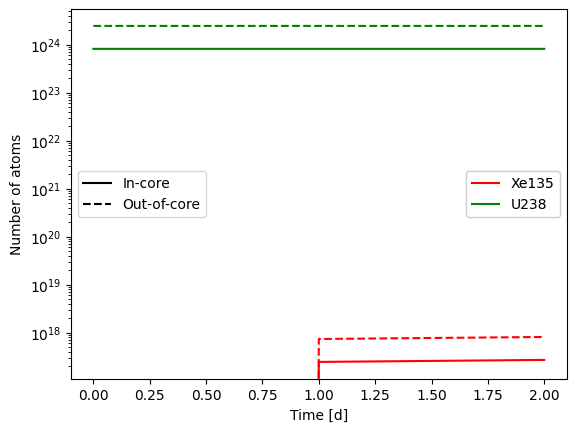

In [53]:
res = openmc.deplete.Results('depletion_results.h5')

atoms_core = dict()
atoms_ofc = dict()

for nuc in res[0].index_nuc.keys():
    atoms_core[nuc] = res.get_atoms(uf4, nuc)[1]
    atoms_ofc[nuc] = res.get_atoms(ofc_uf4, nuc)[1]

line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
line3 = Line2D([0], [0], color='r')
line4 = Line2D([0], [0], color='g')
labels1 = ['In-core', 'Out-of-core']
labels2 = ['Xe135', 'U238']
fig, ax = plt.subplots()
ax.plot(atoms_core['Xe135'], color='r')
ax.plot(atoms_ofc['Xe135'], '--', color='r')
ax.plot(atoms_core['U238'], color='g')
ax.plot(atoms_ofc['U238'], '--', color='g')
leg1=plt.legend([line1, line2],labels1,loc='center left')
leg2=plt.legend([line3, line4],labels2,loc='center right')
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_xlabel('Time [d]')
ax.set_ylabel('Number of atoms')
ax.set_yscale('log')
plt.show()

As we can verify by plotting U238 and Xe135 number of atoms, out-of-core invetory is approximately 3 times the one in-core, as suggested by the volume ratio. 

We can now compute the total number of neutrons emitted in core and our core, by knowing the precursor nuclides distribution between in-core and out-core. 
All the nuclides with $(\beta-,n)$ decay mode are considered delayed neutrons precrusors. 

In [54]:
def add_zero(elm):
    if len(elm) == 1:
        elm = '00'+elm
    elif len(elm) == 2:
        elm = '0'+elm
    return elm

In [55]:
def make_file_string(nuc):
    elm=re.split(r'(\d+|\s+)', nuc)[0]
    A=re.split(r'(\d+|\s+)', nuc)[1]
    Z=openmc.data.ATOMIC_NUMBER[elm]
    A=add_zero(A)
    Z=add_zero(str(Z))
    return f'dec-{Z}_{elm}_{A}.endf'

In [56]:
# if beta-,n decay mode is present, the nuclide is a delayed neutron precursor
def get_dnp(nuc):    
    file = make_file_string(nuc)
    path = '/home/lorenzo/ca_depletion_chains/ENDF-B-VIII.0/ENDF-B-VIII.0_decay'
    if file in os.listdir(path):
        decay_data=openmc.data.Decay.from_endf(f'{path}/{file}')  
        for mode in decay_data.modes:
            if all(decay in mode.modes for decay in ['beta-', 'n']):
                return nuc

In [57]:
dnp=[]
for nuc in res[0].index_nuc:
    if get_dnp(nuc):
        dnp.append(nuc)

In [58]:
# DNP Atoms Dictionaries 
atoms_core_dnp = {nuc: atoms_core[nuc] for nuc in dnp}
atoms_ofc_dnp = {nuc: atoms_ofc[nuc] for nuc in dnp}

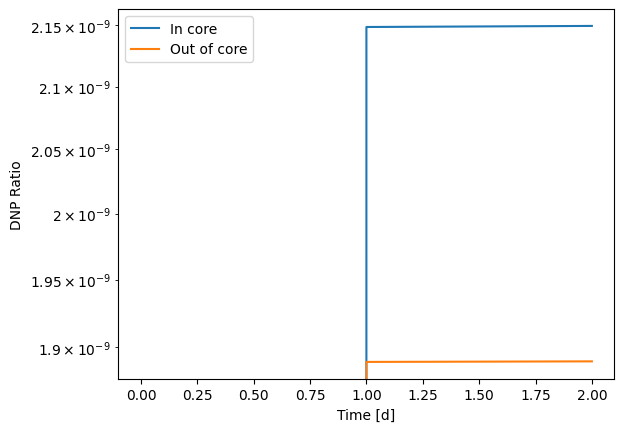

DNP Ratio: [0.87929937 0.87912878]


In [65]:
# Calculate DNP ratios
beta_core = sum(atoms_core_dnp.values())/sum(atoms_core.values())
beta_ofc = sum(atoms_ofc_dnp.values())/sum(atoms_ofc.values())
fig, ax = plt.subplots()
ax.plot(beta_core, label='In core')
ax.plot(beta_ofc, label='Out of core')
plt.legend()
ax.set_xlabel('Time [d]')
ax.set_ylabel('DNP Ratio')
ax.set_yscale('log')
plt.show()
print(f'DNP Ratio: {beta_ofc[1:]/beta_core[1:]}')

The DNP Ratio indicates the fraction of delayed neutrons emitted in core. 


# Delayed neutron yield

The delayed neutron emission rate can be calculated as follows \
[oecd-nea link (pag.186)](https://www.oecd-nea.org/dbdata/nds_jefreports/jefreport-17/chapter11.pdf):

$n(t)_d = \sum_i \lambda_i N_i(t) BR_i$

where the branching ratio $BR$ is the probability that the nuclide $i$ undergos a $\beta^-$ decay and emits a neutron.  

Total delayed neutron emission per fission is calculated instead as: 

$ \nu_d = \sum_{i=0}^{DNP} CFY_i \times BR_i $

where $CFY$ is the cumulative fission yield and $BR$ its branching ratio. 

What we need though, is the total delayed neutron emission per total neutrons production in the fuel, \
therefore we want to divide $n(t)$ by the total neutron absorption reaction rate and obtain the delayed \
neutron fraction ($DNF$), sometimes approximated as $\beta$ \
[DNF](https://www.nuclear-power.com/nuclear-power/fission/delayed-neutrons/delayed-neutrons-fraction/): 

$ DNF= \frac{n(t)_d}{TR} =
\frac{\sum_{i=0}^{DNP} \lambda_i \times N_i \times BR_i}{TR} $ $\frac{\text{[neutrons per sec]}}{\text{[Total nuetron abosred per sec]}}$

We can then calculate $ DNF_{ic}$ (in-core) and $ DNF_{ofc}$ (out-of-core), by considering each respective precursors separately. 

Finally the ratio $ \frac{DNF_{ofc}}{DNF_{ic}+DNF_{ofc}}$ represents the fraction of delayed neutrons lost out of core. 


In [62]:
# Total neutron absorption reactio rate (fission + capture)
import numpy as np
tr = 0
for nuc in res[0].index_nuc:
    
    try:
        tr += res.get_reaction_rate(uf4,nuc,'(n,gamma)')[1]
    except:
        pass
    try:
        tr += res.get_reaction_rate(uf4,nuc,'fission')[1]
    except:
        pass


In [63]:
# delayed neutron per second
dn_core = 0
dn_ofc = 0
path = '/home/lorenzo/ca_depletion_chains/ENDF-B-VIII.0/ENDF-B-VIII.0_decay'
for nuc in dnp:
    file = make_file_string(nuc)
    d=openmc.data.Decay.from_endf(f'{path}/{file}')
    mode = [mode for mode in d.modes if all(decay in mode.modes for decay in ['beta-', 'n'])][0]
    dn_core += mode.branching_ratio.n *  d.decay_constant.n * atoms_core[nuc]
    dn_ofc += mode.branching_ratio.n *  d.decay_constant.n * atoms_ofc[nuc]

Total yield U235: [0.01140903 0.01136428]


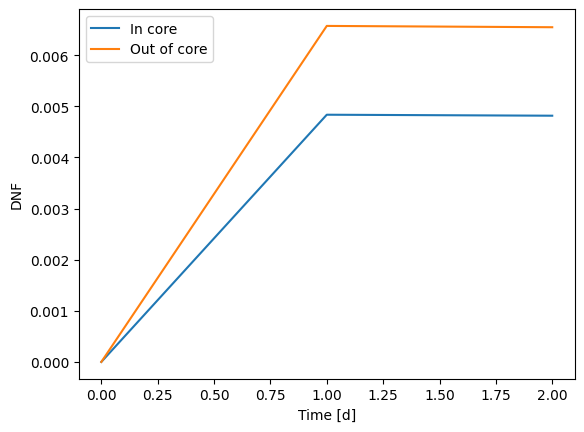

DNF Out-Of-Core: [0.57613264 0.57615068]


In [73]:
#delayed neutron yield (DN/Fiss)
vd_core = dn_core/tr
vd_ofc = dn_ofc/tr 
print(f'Total yield U235: {vd_core[1:]+vd_ofc[1:]}')
fig, ax = plt.subplots()
ax.plot(vd_core, label='In core')
ax.plot(vd_ofc, label='Out of core')
plt.legend()
ax.set_xlabel('Time [d]')
ax.set_ylabel('DNF')
#ax.set_yscale('log')
plt.show()
print(f'DNF Out-Of-Core: {vd_ofc[1:]/(vd_core[1:]+vd_ofc[1:])}')